**Importing Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk import ngrams
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import re
import spacy
import random

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Loading File data

In [3]:
file_path = '/Dataset/BRICS.csv'
data = pd.read_csv(file_path)


In [4]:
data.head(5)

,Unnamed: 0,textDisplay,likeCount,label
0,0,"hurray for Brics nation, I hope this changes t...",0,0
1,1,BRICS are modern Axis Powers😂,0,0
2,2,As France is asked to remove Troops from Niger...,0,0
3,3,BE WARNED,0,0
4,4,"India should kick out from Brics, cause everyo...",0,0


**Basic EDA**

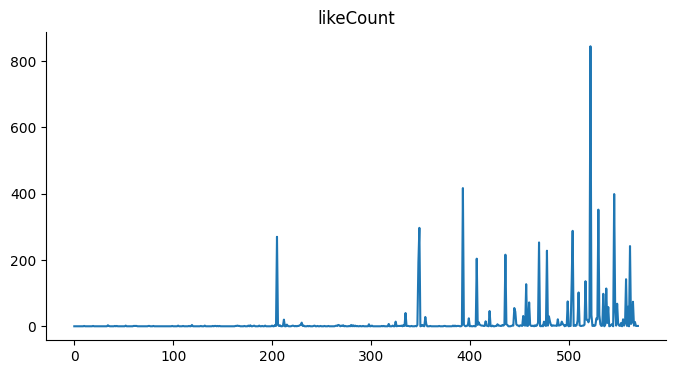

In [5]:
data['likeCount'].plot(kind='line', figsize=(8, 4), title='likeCount')
plt.gca().spines[['top', 'right']].set_visible(False)

In [6]:
print("Missing values:\n", data.isnull().sum())
print("Duplicate rows:", data.duplicated().sum())
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)


Missing values:
 Unnamed: 0     0
textDisplay    0
likeCount      0
label          0
dtype: int64
Duplicate rows: 0


In [7]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join(text.split())
    return text

data['cleaned_text'] = data['textDisplay'].apply(normalize_text)


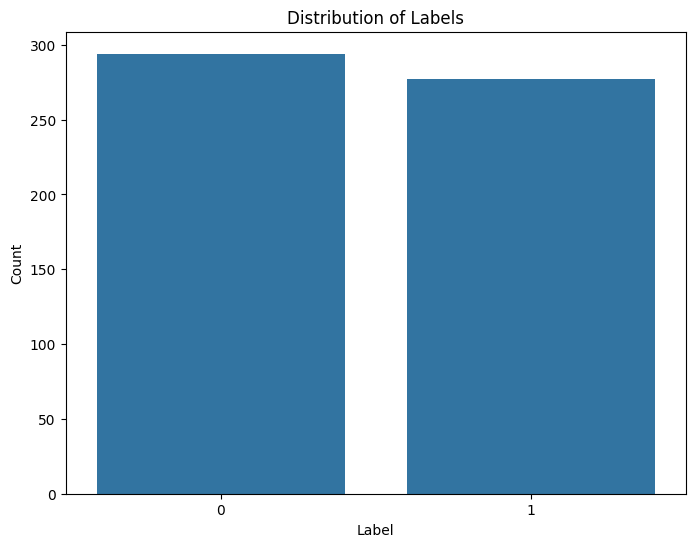

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


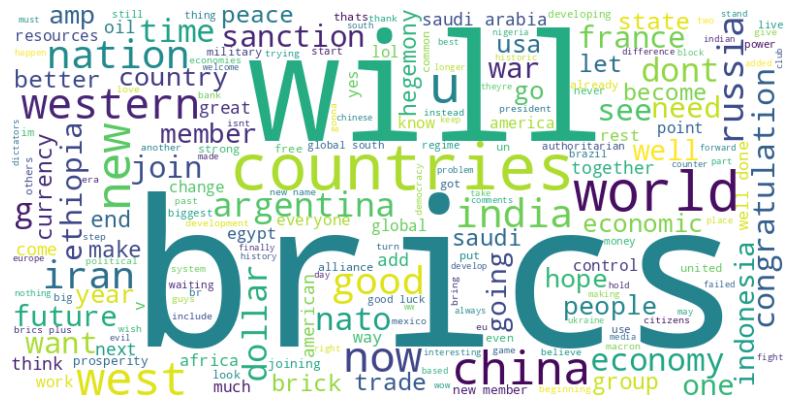

In [9]:
all_words = ' '.join(data['cleaned_text'])
word_cloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [10]:
def get_ngrams(text, n):
    words = text.split()
    if len(words) < n:
        return []
    return [' '.join(grams) for grams in ngrams(words, n)]

bigrams = Counter([bigram for text in data['cleaned_text'] for bigram in get_ngrams(text, 2)])
trigrams = Counter([trigram for text in data['cleaned_text'] for trigram in get_ngrams(text, 3)])

print("Most common bigrams:")
print(bigrams.most_common(10))
print("\nMost common trigrams:")
print(trigrams.most_common(10))


Most common bigrams:
[('of the', 39), ('in the', 38), ('brics is', 28), ('the west', 24), ('will be', 23), ('the world', 22), ('is a', 19), ('the us', 18), ('to be', 18), ('in brics', 17)]

Most common trigrams:
[('of the world', 7), ('iran and saudi', 6), ('in the future', 5), ('there is a', 5), ('and saudi arabia', 5), ('in the past', 5), ('of the west', 5), ('rest of the', 5), ('in the world', 5), ('peace and prosperity', 5)]


**Advance EDA and Data Augmentation**

In [11]:
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

data['cleaned_text'] = data['cleaned_text'].apply(tokenize_and_remove_stopwords)


In [12]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

data['cleaned_text'] = data['cleaned_text'].apply(lemmatize_text)


In [13]:
nlp = spacy.load("en_core_web_sm")

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def synonym_replacement(text, n=1):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    sentence = ' '.join(new_words)
    return sentence

data_augmented = data.copy()

augmented_rows = []
for index, row in data.iterrows():
    if row['label'] == 1:
        augmented_text = synonym_replacement(row['textDisplay'], n=2)
        augmented_rows.append({'textDisplay': augmented_text, 'label': row['label']})
augmented_df = pd.DataFrame(augmented_rows)

data_augmented = pd.concat([data, augmented_df], ignore_index=True)


**Making Data Ready for Model Fitting**

In [14]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
import tensorflow as tf
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import lightgbm as lgb
import xgboost as xgb

In [15]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


model = BertModel.from_pretrained('bert-base-uncased')

def encode_texts(texts):
    encoded_input = tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
    with torch.no_grad():
        model_output = model(**encoded_input)
    return model_output.last_hidden_state[:, 0, :].numpy()
model_plt={}
X_train, X_test, y_train, y_test = train_test_split(data_augmented['textDisplay'], data_augmented['label'], test_size=0.2, random_state=42)
X_train_bert = encode_texts(X_train)
X_test_bert = encode_texts(X_test)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**LSTM Model**

Epoch 1/5
22/22 [==============================] - 15s 497ms/step - loss: 0.6557 - accuracy: 0.6460 - val_loss: 0.6536 - val_accuracy: 0.6176
Epoch 2/5
22/22 [==============================] - 9s 421ms/step - loss: 0.6032 - accuracy: 0.6652 - val_loss: 0.6195 - val_accuracy: 0.6235
Epoch 3/5
22/22 [==============================] - 8s 374ms/step - loss: 0.4291 - accuracy: 0.7876 - val_loss: 0.5234 - val_accuracy: 0.7176
Epoch 4/5
22/22 [==============================] - 10s 455ms/step - loss: 0.2081 - accuracy: 0.9145 - val_loss: 0.6212 - val_accuracy: 0.7588
Epoch 5/5
6/6 [==============================] - 2s 150ms/step
LSTM Model:
              precision    recall  f1-score   support

           0       0.71      0.62      0.66        65
           1       0.78      0.85      0.81       105

    accuracy                           0.76       170
   macro avg       0.75      0.73      0.74       170
weighted avg       0.76      0.76      0.75       170

Accuracy: 0.7588235294117647


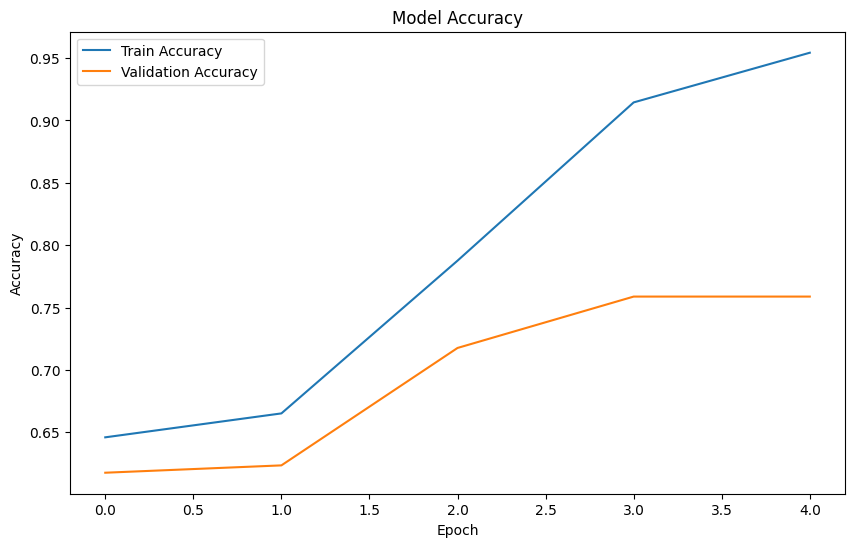

In [16]:
max_length = 128
vocab_size = 30522

X_train_seq = pad_sequences(X_train.apply(lambda x: tokenizer.encode(x, max_length=max_length, truncation=True)), maxlen=max_length)
X_test_seq = pad_sequences(X_test.apply(lambda x: tokenizer.encode(x, max_length=max_length, truncation=True)), maxlen=max_length)

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history=model_lstm.fit(X_train_seq, y_train, epochs=5, batch_size=32, validation_data=(X_test_seq, y_test))

y_pred_lstm = (model_lstm.predict(X_test_seq) > 0.5).astype("int32")
print("LSTM Model:")
print(classification_report(y_test, y_pred_lstm))
print("Accuracy:", accuracy_score(y_test, y_pred_lstm))
model_plt['LSTM']=accuracy_score(y_test, y_pred_lstm)

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


**Simple Neural Network**

Epoch 1/10
22/22 [==============================] - 1s 13ms/step - loss: 0.6744 - accuracy: 0.6209 - val_loss: 0.6474 - val_accuracy: 0.6235
Epoch 2/10
22/22 [==============================] - 0s 5ms/step - loss: 0.5661 - accuracy: 0.7168 - val_loss: 0.6210 - val_accuracy: 0.6824
Epoch 3/10
22/22 [==============================] - 0s 5ms/step - loss: 0.5384 - accuracy: 0.7330 - val_loss: 0.6655 - val_accuracy: 0.6471
Epoch 4/10
22/22 [==============================] - 0s 5ms/step - loss: 0.5102 - accuracy: 0.7507 - val_loss: 0.6186 - val_accuracy: 0.6824
Epoch 5/10
22/22 [==============================] - 0s 5ms/step - loss: 0.4802 - accuracy: 0.7847 - val_loss: 0.6069 - val_accuracy: 0.6824
Epoch 6/10
22/22 [==============================] - 0s 5ms/step - loss: 0.4539 - accuracy: 0.7979 - val_loss: 0.5983 - val_accuracy: 0.7118
Epoch 7/10
22/22 [==============================] - 0s 5ms/step - loss: 0.4332 - accuracy: 0.8127 - val_loss: 0.5736 - val_accuracy: 0.7588
Epoch 8/10
22/22 [=

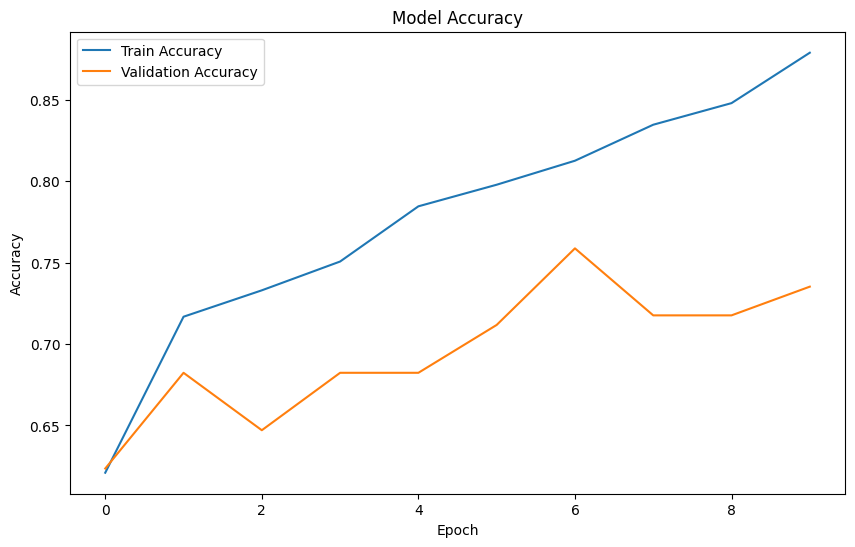

In [17]:
nn_model = Sequential()
nn_model.add(Dense(128, activation='relu', input_dim=X_train_bert.shape[1]))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history=nn_model.fit(X_train_bert, y_train, epochs=10, batch_size=32, validation_data=(X_test_bert, y_test))

y_pred_nn = (nn_model.predict(X_test_bert) > 0.5).astype("int32")

print("Simple Neural Network with BERT:")
print(classification_report(y_test, y_pred_nn))
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
model_plt['Simple Neural Network'] = accuracy_score(y_test, y_pred_nn)
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


**Stacking Classifier(3 Base models)**

Stacking Classifier with BERT:
              precision    recall  f1-score   support

           0       0.83      0.37      0.51        65
           1       0.71      0.95      0.81       105

    accuracy                           0.73       170
   macro avg       0.77      0.66      0.66       170
weighted avg       0.75      0.73      0.70       170

Accuracy: 0.7294117647058823


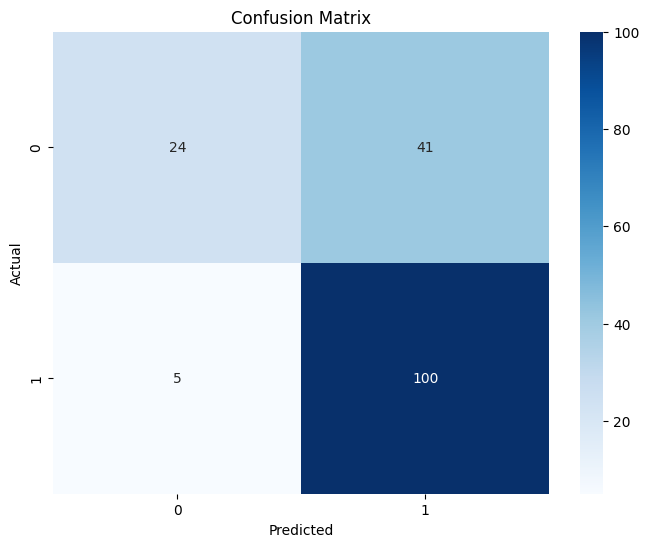

In [18]:
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

meta_model = LogisticRegression()
stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
history=stacking.fit(X_train_bert, y_train)
y_pred_stacking = stacking.predict(X_test_bert)
print("Stacking Classifier with BERT:")
print(classification_report(y_test, y_pred_stacking))
print("Accuracy:", accuracy_score(y_test, y_pred_stacking))
model_plt['Stacking Classifier with BERT'] = accuracy_score(y_test, y_pred_stacking)
conf_matrix = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**LGBM Classifier**

[LightGBM] [Info] Number of positive: 449, number of negative: 229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 173886
[LightGBM] [Info] Number of data points in the train set: 678, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.662242 -> initscore=0.673301
[LightGBM] [Info] Start training from score 0.673301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

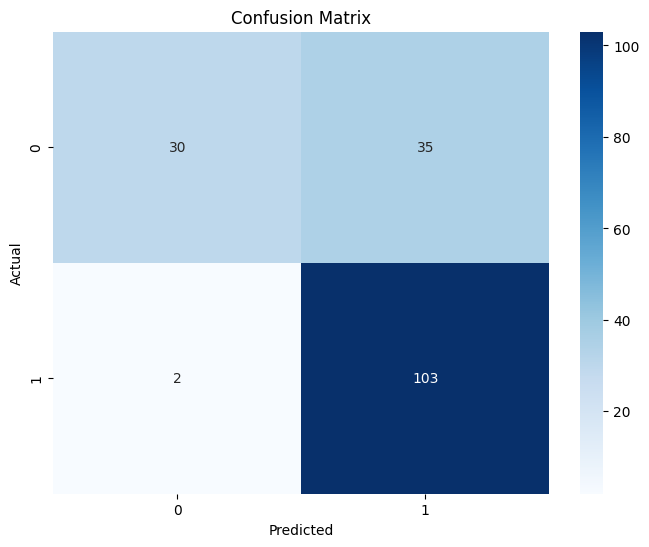

In [19]:
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_bert, y_train)

y_pred_lgb = lgb_model.predict(X_test_bert)

print("LightGBM with BERT:")
print(classification_report(y_test, y_pred_lgb))
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
model_plt['LightGBM with BERT'] = accuracy_score(y_test, y_pred_lgb)
conf_matrix = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Multi-Layer Perceptron**

Multi-layer Perceptron with BERT:
              precision    recall  f1-score   support

           0       0.73      0.46      0.57        65
           1       0.73      0.90      0.80       105

    accuracy                           0.73       170
   macro avg       0.73      0.68      0.68       170
weighted avg       0.73      0.73      0.71       170

Accuracy: 0.7294117647058823


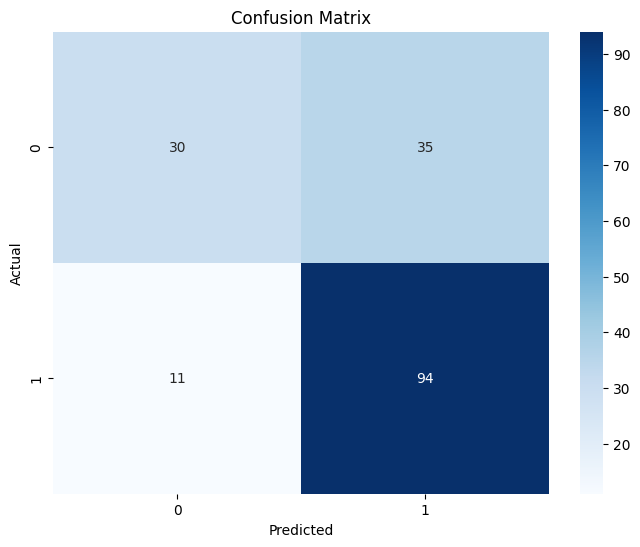

In [20]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_train_bert, y_train)

y_pred_mlp = mlp.predict(X_test_bert)

print("Multi-layer Perceptron with BERT:")
print(classification_report(y_test, y_pred_mlp))
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
model_plt['Multi-layer Perceptron with BERT'] = accuracy_score(y_test, y_pred_mlp)

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



**Advance Stacking Classifier(5 base models)**

[LightGBM] [Info] Number of positive: 449, number of negative: 229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 173886
[LightGBM] [Info] Number of data points in the train set: 678, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.662242 -> initscore=0.673301
[LightGBM] [Info] Start training from score 0.673301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

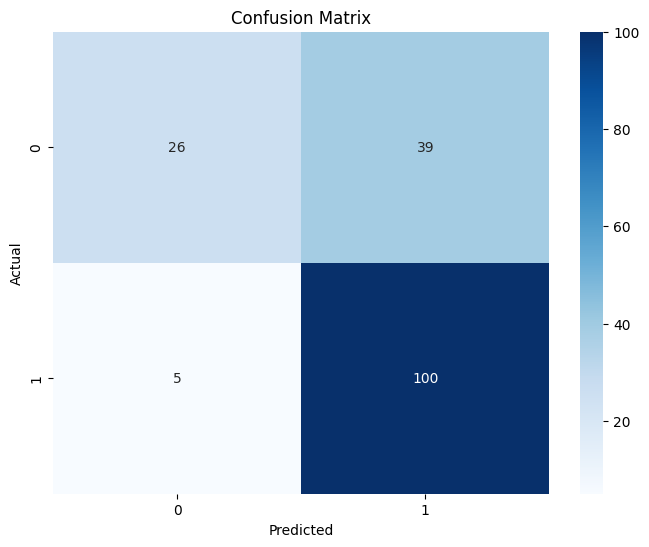

In [21]:
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lgb', lgb.LGBMClassifier(random_state=42))
]

meta_model = LogisticRegression()

stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

stacking.fit(X_train_bert, y_train)

y_pred_stacking = stacking.predict(X_test_bert)

print("Advanced Stacking with BERT:")
print(classification_report(y_test, y_pred_stacking))
print("Accuracy:", accuracy_score(y_test, y_pred_stacking))
model_plt['Advanced Stacking with BERT'] = accuracy_score(y_test, y_pred_stacking)
conf_matrix = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Plotting Results**

<ipython-input-22-0f04b9a2c7a1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=df, palette='viridis')


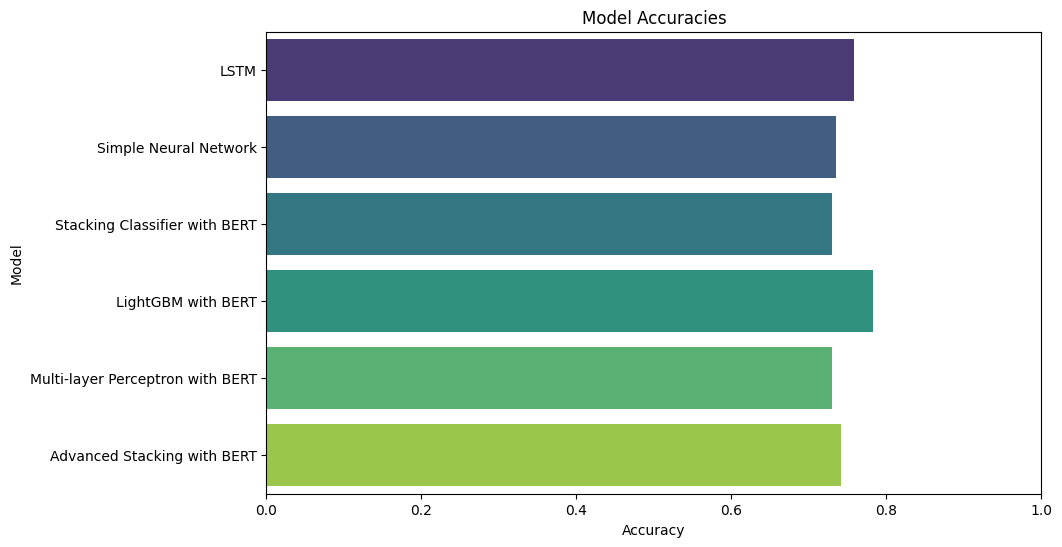

In [22]:
data = list(model_plt.items())
df = pd.DataFrame(data, columns=['Model', 'Accuracy'])


plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=df, palette='viridis')
plt.xlabel('Accuracy')
plt.title('Model Accuracies')
plt.xlim(0, 1)
plt.show()


**Best Model converting to file for webapp**

In [24]:
import pickle
with open('lgb_model.pkl', 'wb') as file:
    pickle.dump(lgb_model, file)